In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
import pywt


plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体
plt.rcParams['axes.unicode_minus'] = False     # 解决负号显示问题

def normalize(data, method='minmax', min_value=None, max_value=None):
    """
    多方法归一化函数
    
    参数:
    - data: 需要归一化的数组或数据框列
    - method: 归一化方法，可选['minmax', 'standard', 'log', 'log_minmax']
    - min_value: 最小值（可选）
    - max_value: 最大值（可选）
    
    返回:
    - 归一化后的数据
    - 用于反归一化的参数字典
    """
    params = {}
    
    if method == 'minmax':
        if min_value is None:
            min_value = data.min()
        if max_value is None:
            max_value = data.max()
        normalized_data = (data - min_value) / (max_value - min_value)
        params = {'min_value': min_value, 'max_value': max_value}
        
    elif method == 'standard':
        scaler = StandardScaler()
        normalized_data = scaler.fit_transform(data.values.reshape(-1, 1)).flatten()
        normalized_data = pd.Series(normalized_data, index=data.index)  # 转换回Series
        params = {'mean': scaler.mean_, 'std': scaler.scale_}
        
    elif method == 'log':
        normalized_data = np.log1p(data)
        params = {'method': 'log'}
        
    elif method == 'log_minmax':
        # 先对数变换
        log_data = np.log1p(data)
        # 再归一化
        if min_value is None:
            min_value = log_data.min()
        if max_value is None:
            max_value = log_data.max()
        normalized_data = (log_data - min_value) / (max_value - min_value)
        params = {'min_value': min_value, 'max_value': max_value}
        
    else:
        raise ValueError("不支持的归一化方法")
        
    return normalized_data, params

def denormalize(normalized_data, params, method='minmax'):
    """
    多方法反归一化函数
    
    参数:
    - normalized_data: 归一化后的数据
    - params: 归一化参数字典
    - method: 归一化方法，需要与normalize函数使用的方法相同
    
    返回:
    - 反归一化后的原始数据
    """
    if method == 'minmax':
        original_data = normalized_data * (params['max_value'] - params['min_value']) + params['min_value']
        
    elif method == 'standard':
        original_data = normalized_data * params['std'] + params['mean']
        
    elif method == 'log':
        original_data = np.expm1(normalized_data)
        
    elif method == 'log_minmax':
        # 先反归一化
        log_data = normalized_data * (params['max_value'] - params['min_value']) + params['min_value']
        # 再指数变换
        original_data = np.expm1(log_data)
        
    else:
        raise ValueError("不支持的归一化方法")
        
    return original_data


# 读取数据
df = pd.read_csv(r'C:\Users\12919\Desktop\24能源经济\results\clustering_results_cleaned.csv', header=0).iloc[:-24, 1:]
target=pd.read_csv(r'C:\Users\12919\Desktop\24能源经济\results\clustering_results_cleaned.csv', header=0).iloc[-24:, 1:]
df["Power (MW)"], normalize_params = normalize(df["Power (MW)"])



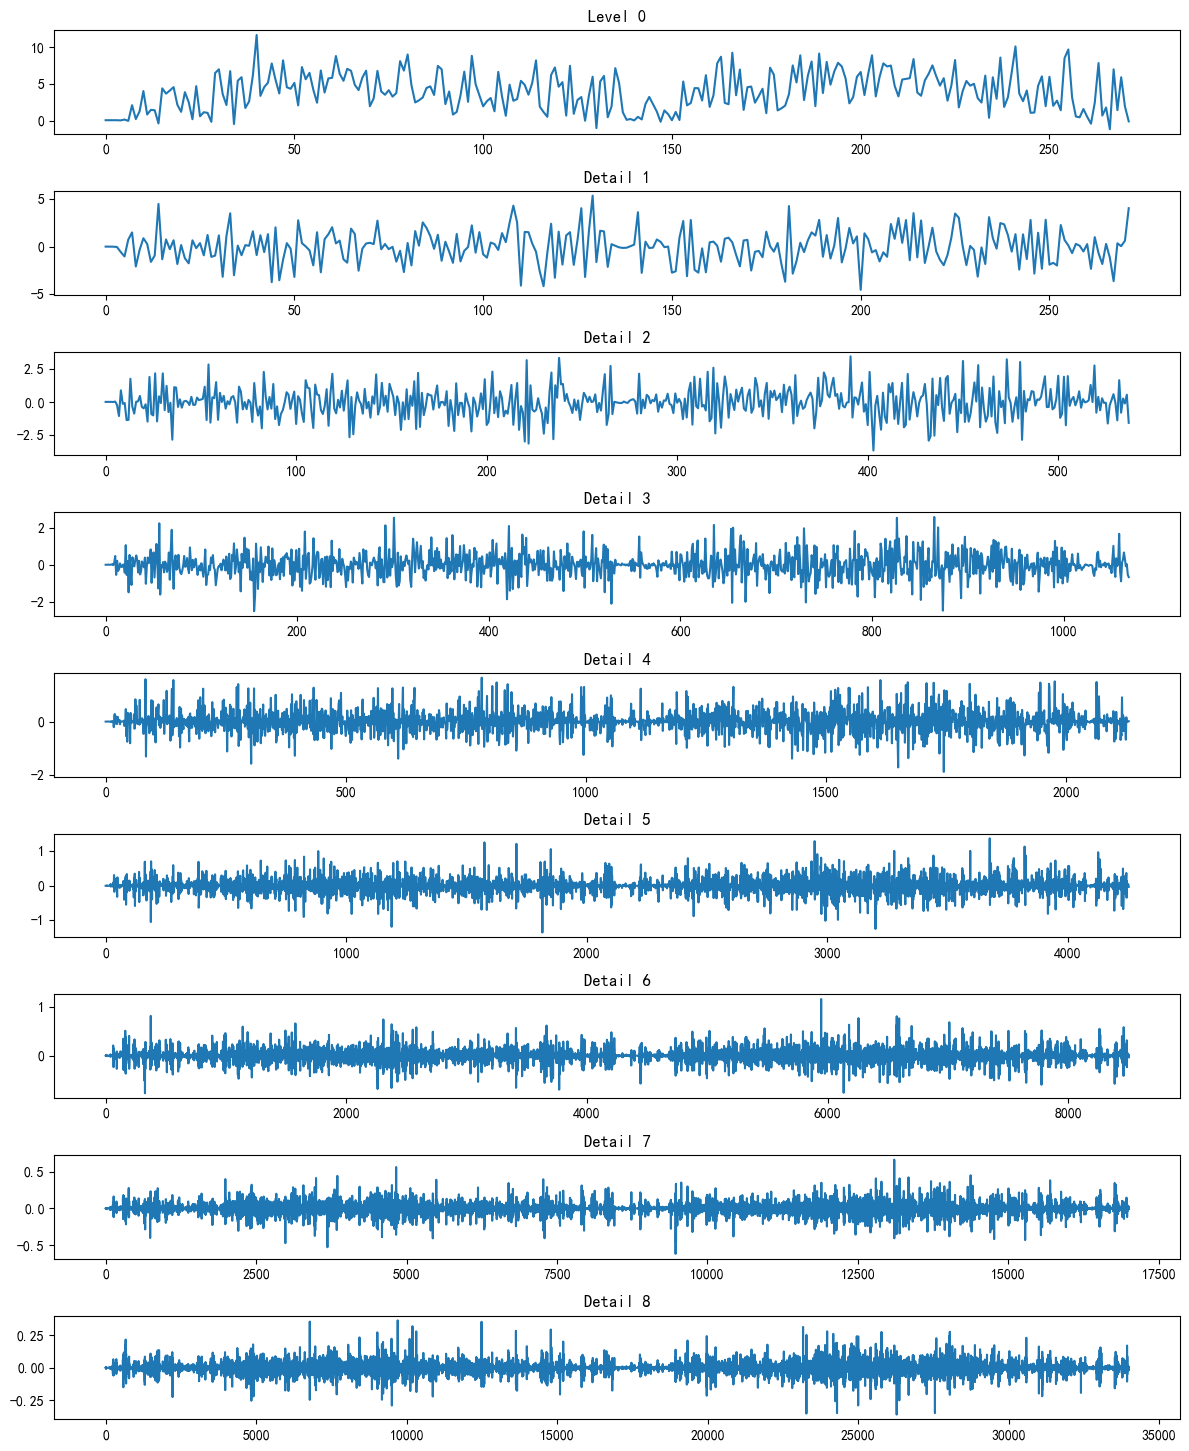

In [3]:
def wavelet_decomposition(data, wavelet='db4', level=3):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return coeffs

# 参数设置
wavelet_type = 'db4'  # Daubechies小波
decomp_level = 8      # 分解层数（根据数据周期特性调整）

# 执行分解
coeffs = wavelet_decomposition(df['Power (MW)'], wavelet=wavelet_type, level=decomp_level)

# 可视化分解结果
plt.figure(figsize=(12, 16))
for i, coeff in enumerate(coeffs):
    plt.subplot(len(coeffs)+1, 1, i+1)
    plt.plot(coeff)
    plt.title(f'Level {i}' if i == 0 else f'Detail {i}')
plt.tight_layout()
plt.show()

In [17]:
def sarima_forecast(component, order, seasonal_order, steps):
    model = SARIMAX(component,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=steps)
    return forecast

# 预测参数设置
forecast_steps = 24  # 6小时（15分钟×24）

# 各分量的SARIMA参数（需要根据实际数据调整）
params = {
    'level_0': {'order': (1,1,1), 'seasonal_order': (1,1,1,96)},  # 日周期
    'detail_1': {'order': (2,0,2), 'seasonal_order': (0,0,0,0)},
    'detail_2': {'order': (1,1,0), 'seasonal_order': (1,0,1,24)},
    'detail_3': {'order': (0,1,1), 'seasonal_order': (0,0,0,0)},
    'detail_4': {'order': (1,0,0), 'seasonal_order': (0,0,0,0)},
    'detail_5': {'order': (0,1,0), 'seasonal_order': (0,0,0,0)},
    'detail_6': {'order': (0,0,1), 'seasonal_order': (0,0,0,0)},
    # 'detail_7': {'order': (1,0,0), 'seasonal_order': (0,0,0,0)},
    # 'detail_8': {'order': (1,0,0), 'seasonal_order': (0,0,0,0)},

}

# 对各分量分别预测
forecasts = []
for i, (coeff, param) in enumerate(zip(coeffs, params.values())):
    forecast = sarima_forecast(coeff, 
                             param['order'],
                             param['seasonal_order'],
                             forecast_steps)
    forecasts.append(forecast)

In [19]:
print(len(forecasts))
print([len(x) for x in forecasts])

7
[24, 24, 24, 24, 24, 24, 24]


In [20]:

start_time = pd.Timestamp('2019-01-01 00:00:00')
df.index = pd.date_range(start=start_time, periods=len(df), freq='15T')

# 构建完整的系数数组
# 使用原始分解系数的长度和结构，将预测的分量替换到原始系数中
reconstructed_coeffs = [np.concatenate([coeff[:-forecast_steps], forecast]) for coeff, forecast in zip(coeffs, forecasts)]

# 小波重构
forecast_reconstructed = pywt.waverec(reconstructed_coeffs, wavelet_type)

# 处理边界效应（保留中间有效部分）
valid_length = forecast_steps
final_forecast = forecast_reconstructed[-valid_length:]

# 生成时间索引
last_timestamp = df.index[-1]
forecast_index = pd.date_range(start=last_timestamp + pd.Timedelta(minutes=15),
                               periods=forecast_steps,
                               freq='15T')

# 创建预测结果DataFrame
forecast_df = pd.DataFrame({'预测功率': final_forecast},
                          index=forecast_index)

C:\Users\12919\AppData\Local\Temp\ipykernel_47772\3551185250.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.index = pd.date_range(start=start_time, periods=len(df), freq='15T')
C:\Users\12919\AppData\Local\Temp\ipykernel_47772\3551185250.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast_index = pd.date_range(start=last_timestamp + pd.Timedelta(minutes=15),


In [21]:
denormalize(df['Power (MW)'][-100:],params=normalize_params,method="minmax")

2020-12-08 02:00:00    38.211433
2020-12-08 02:15:00    35.365612
2020-12-08 02:30:00    24.554340
2020-12-08 02:45:00    21.935904
2020-12-08 03:00:00    20.838787
                         ...    
2020-12-09 01:45:00     1.965427
2020-12-09 02:00:00     0.580533
2020-12-09 02:15:00     0.153482
2020-12-09 02:30:00     0.343204
2020-12-09 02:45:00     0.316913
Freq: 15min, Name: Power (MW), Length: 100, dtype: float64

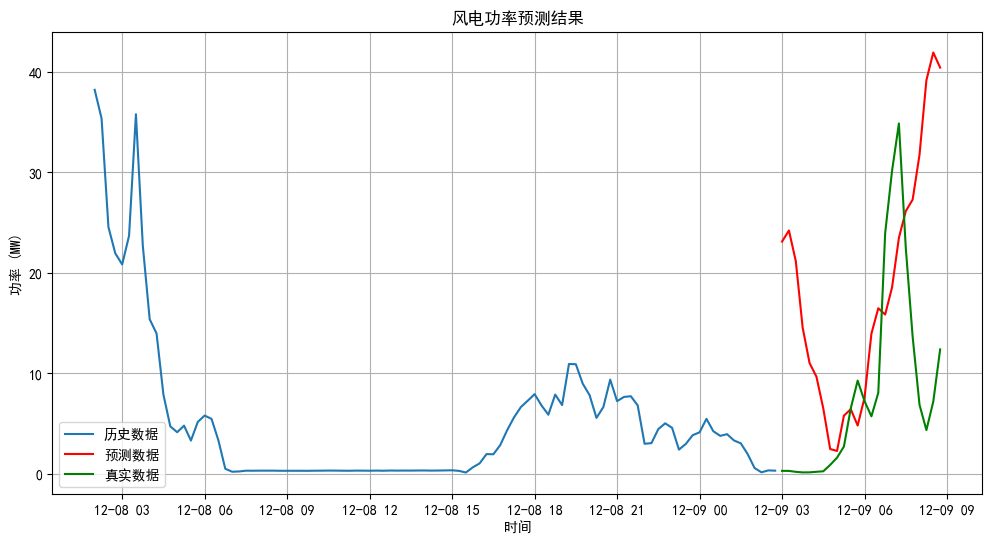

In [24]:
# 可视化对比
plt.figure(figsize=(12,6))
history_values=denormalize(df['Power (MW)'][-100:],params=normalize_params,method="minmax")
predict_values=denormalize(forecast_df['预测功率'],params=normalize_params,method="minmax")
plt.plot(df.index[-100:],history_values , label='历史数据')
plt.plot(forecast_df.index, predict_values, label='预测数据', color='red')
plt.plot(forecast_df.index, target["Power (MW)"], label='真实数据', color='green')
plt.title('风电功率预测结果')
plt.ylabel('功率 (MW)')
plt.xlabel('时间')
plt.legend()
plt.grid()
plt.show()

# 保存结果
# forecast_df.to_excel('风电功率预测结果.xlsx')

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

def evaluate_forecast(true_values, predicted_values):
    """
    评估预测结果并输出误差指标
    
    参数:
    - true_values: 真实值
    - predicted_values: 预测值
    
    返回:
    - 误差指标（MSE, MAE, R², RMSE）
    """
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)
    rmse = math.sqrt(mse)  # 计算均方根误差
    
    print(f"均方误差 (MSE): {mse}")
    print(f"平均绝对误差 (MAE): {mae}")
    print(f"决定系数 (R²): {r2}")
    print(f"均方根误差 (RMSE): {rmse}")
    
    return mse, mae, r2, rmse

# 提取真实值
true_values = target["Power (MW)"].values

# 反归一化预测值
predicted_values = denormalize(forecast_df['预测功率'], params=normalize_params, method="minmax")

# 评估预测结果
evaluate_forecast(true_values, predicted_values)

均方误差 (MSE): 271.30622447353073
平均绝对误差 (MAE): 12.767739978573061


(271.30622447353073, 12.767739978573061)